### Packages

In [1]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from IPython.display import SVG

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
# Not uploading the following files to github since its heavily inspired from coursera course 
# This has keras function to implement inception network and load weights
from utils import *
from inception_network import *

### Data

In [6]:
K.set_image_data_format('channels_first')

In [7]:
## Input: RGB images of size (96, 96) 
## => Shape = (# of examples, 3, 96, 96)

## Output: Encoding of 128 bits 
## => Shape = (# of examples, 128)

### Model: 

#### Recognition vs Verification

* Verification: 1:1 problem. 
    - Given id and image, check if they match  
    
    
* Recognition: 1:K problem. 
    - Given image, find the person's id among K ids
    - Instead of pixel value comparison, learn encoding for image.

#### Triplet loss function and output encoding

In [8]:
# Custom loss function for Keras
# Assumption is training data has triplets (anchor, positive, negative) images consecutively in sequence while training 
def triplet_loss_func(y_true, y_pred, alpha = 0.2):

    # y_true can be ignored here, since loss is not dependent on it
    # y_pred is the only one that matters. Each of anchor, positive, negative have shape of (None, 128)
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]    
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)), axis = -1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)), axis = -1)
    loss = tf.add(tf.subtract(pos_dist,neg_dist),alpha)
    total_loss = tf.reduce_sum(tf.maximum(loss,0.0))
    
    print("anchor.shape, positive.shape, negative.shape",anchor.shape, positive.shape, negative.shape)
    print("pos_dist.shape, neg_dist.shape ",pos_dist.shape, neg_dist.shape)
    print("loss.shape, total_loss.shape:",loss.shape, total_loss.shape)
    
    return total_loss

In [9]:
# Get encoding for image
def get_image_encoding(image_file, model):
    
    img_in = cv2.imread(image_file, 1)   
    img = img_in[...,::-1]
    print("Shape of image is: ", img.shape)
    
    img_normalized = np.transpose(img, (2,0,1))/255.0 ; # Change from (96,96,3) to (3,96,96)
    img_normalized = np.around(img_normalized, decimals=12)  ; # Round it
    x = np.array([img_normalized])  ; # Since its per minibatch
    print("Shape of normalized image input to model is: ", x.shape)
    
    embedding = model.predict_on_batch(x)
    
    return embedding

#### Model

In [10]:
## Create inception model
model = inception_face_recognition_model(input_shape=(3, 96, 96))

In [11]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 96, 96)     0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 3, 102, 102)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 64, 48, 48)    9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn1 (BatchNormalization)         (None, 64, 48, 48)    256         conv1[0][0]                      
___________________________________________________________________________________________

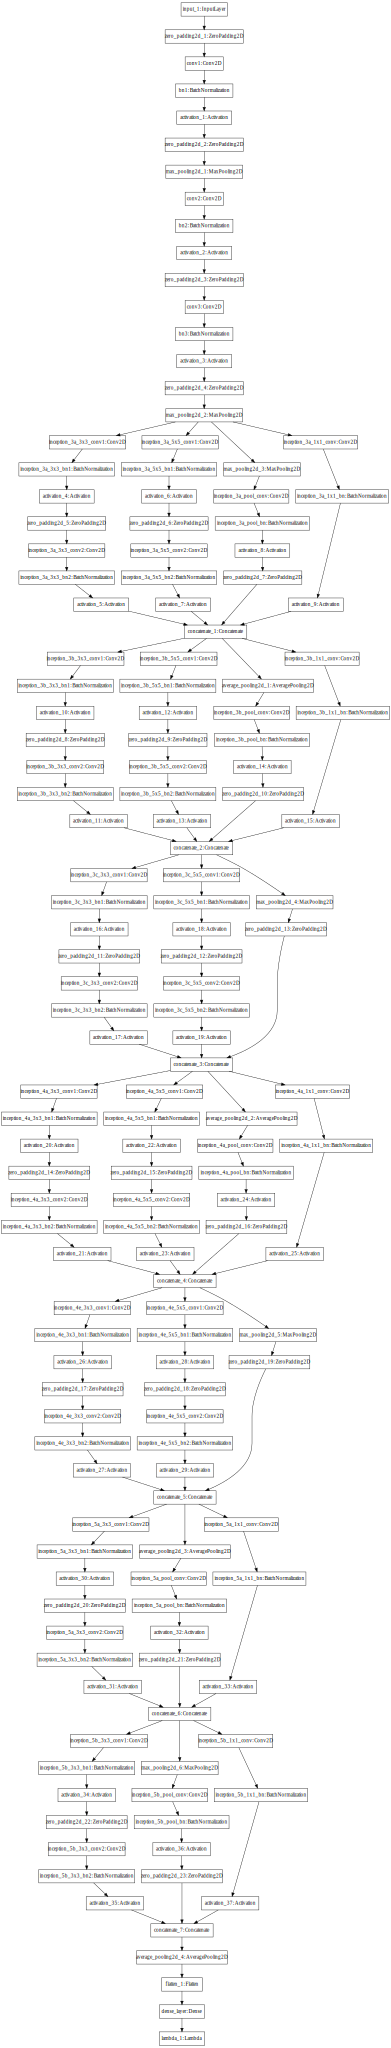

In [12]:
#plot_model(model, to_file="scratch/inception_model.png")
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [13]:
# Compile
model.compile(optimizer = 'adam', loss = triplet_loss_func, metrics = ['accuracy'])

anchor.shape, positive.shape, negative.shape (128,) (128,) (128,)
pos_dist.shape, neg_dist.shape  () ()
loss.shape, total_loss.shape: () ()


#### Train the model (instead of transfer learning)

In [14]:
# Train dataset
train_dataset = h5py.File('data/train_face.h5', "r")
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) 
train_set_y_orig = np.array(train_dataset["train_set_y"][:]) 
train_set_x_orig.shape, train_set_y_orig.shape

((426, 96, 96, 3), (426,))

In [15]:
# Change x dimensions
train_set_x = np.transpose(train_set_x_orig, (0,3,1,2)) ; # Change from (m, 96, 96, 3) to (m, 3, 96, 96)
train_set_x = np.around(train_set_x, decimals=12)  ; # Round it
train_set_x.shape

(426, 3, 96, 96)

In [16]:
# Change y type to integer to avoid keras error "ValueError: could not convert string to float: 'arnaud'"
# The value of y should not matter since loss function is independent of it
train_set_y = pd.get_dummies(train_set_y_orig).values.argmax(1)
train_set_y.shape

(426,)

In [17]:
type(train_set_y_orig[0]), type(train_set_y[0])

(numpy.bytes_, numpy.int64)

In [18]:
# Fit the model
model.fit(train_set_x, train_set_y, epochs = 1, batch_size = 3, verbose = 1)

Epoch 1/1
426/426 [==============================] - 54s - loss: 0.2067 - acc: 0.0000e+00    


#### Transfer Learning

In [19]:
## Create inception model
model = inception_face_recognition_model(input_shape=(3, 96, 96))
# Compile
model.compile(optimizer = 'adam', loss = triplet_loss_func, metrics = ['accuracy'])

anchor.shape, positive.shape, negative.shape (128,) (128,) (128,)
pos_dist.shape, neg_dist.shape  () ()
loss.shape, total_loss.shape: () ()


In [20]:
## Using pretrained weights
load_FaceNet_weights(model)

#### Face Verification

In [21]:
# Image Database
image_db = {}
image_db["X"] = get_image_encoding("data/X.jpg", model)
image_db["Y"] = get_image_encoding("data/Y.jpg", model)
image_db["Z"] = get_image_encoding("data/Z.jpg", model)
print("Image database loaded")

Shape of image is:  (96, 96, 3)
Shape of normalized image input to model is:  (1, 3, 96, 96)
Shape of image is:  (96, 96, 3)
Shape of normalized image input to model is:  (1, 3, 96, 96)
Shape of image is:  (96, 96, 3)
Shape of normalized image input to model is:  (1, 3, 96, 96)
Image database loaded


In [22]:
# Check if distance between input_id and image is less than threshold 
def face_verification(input_id, image_file, model):
    
    # Get encoding and L2 distanace from input id
    img_encoding = get_image_encoding(image_file, model)    
    dist = np.linalg.norm(image_db[input_id] - img_encoding)    
    # threshold of 0.6
    if dist < 0.6:
        print("Id verified!, as ", input_id)
    else:
        print("Id doesn't match!, with ", input_id)
    print("\n")

In [23]:
# Check X
face_verification('X', 'data/X.jpg', model)

# Check Y
face_verification('Y', 'data/X.jpg', model)

Shape of image is:  (96, 96, 3)
Shape of normalized image input to model is:  (1, 3, 96, 96)
Id verified!, as  X


Shape of image is:  (96, 96, 3)
Shape of normalized image input to model is:  (1, 3, 96, 96)
Id doesn't match!, with  Y




#### Face Recognition

In [24]:
# Given a image, find nearest embedding in database
def find_id(image_file, model):
    
    # Get image encoding 
    img_encoding = get_image_encoding(image_file, model)    
    
    # Get id with minimum L2 distance
    min_dist = 100    
    for (db_id, db_image_enc) in image_db.items():        
        dist = np.linalg.norm(db_image_enc - img_encoding)
        if dist < min_dist:
            min_dist = dist
            found_id = db_id
    
    # Check if less than threshold
    if min_dist > 0.7:
        print("Id not found")
        return
    print ("Id found: {} with distance {}".format(found_id,min_dist))
    print("\n")

In [25]:
# Find X
find_id('data/X.jpg', model)

# Find Y
find_id('data/Y.jpg', model)

# Find M
find_id('data/M.jpg', model)

Shape of image is:  (96, 96, 3)
Shape of normalized image input to model is:  (1, 3, 96, 96)
Id found: X with distance 0.0


Shape of image is:  (96, 96, 3)
Shape of normalized image input to model is:  (1, 3, 96, 96)
Id found: Y with distance 0.0


Shape of image is:  (96, 96, 3)
Shape of normalized image input to model is:  (1, 3, 96, 96)
Id not found
